In [4]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
import seaborn as sns

from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import warnings
warnings.filterwarnings("ignore")

colors = ["#54478c", "#2c699a", "#048ba8", "#0db39e", "#16db93", 
          "#83e377", "#b9e769", "#efea5a", "#f1c453", "#f29e4c", "#ffa62b"]

In [5]:
# Veriyi okuma
churn = pd.read_csv("churn2.csv")

# Veriyi kopyalama
df = churn.copy()

df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [6]:
# Kullanılmayacak sütunları kaldırma
df = df.drop(columns = ["RowNumber", "Surname"])

df.head(10)

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,15574012,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,15592531,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,15656148,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,15792365,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,15592389,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [7]:
# Featureların istenen tiplere çevrilmesi
df["Balance"] = df["Balance"].astype("int64") 
df["EstimatedSalary"] = df["EstimatedSalary"].astype("int64")

In [8]:
# Yaş sütununun gruplara ayrılması
def age_group_calc(element): 
    if element <= 25:
        return "18-25"
    elif 25 < element <= 35:
        return "26-35"
    elif 35 < element <= 50:
        return "36-50"
    elif 50 < element:
        return "50+"

df["AgeGroup"] = df["Age"].apply(age_group_calc)

# Bakiyesi 0 olan müşterilerin ayırt edilmesi
df['IsZeroBalance'] = np.where(df['Balance'] == 0, 1, 0)

# CreditScore, EstimatedSalary ve Balance sütunların gruplara ayrılması
df["CreditScoreGroup"] = pd.qcut(df["CreditScore"], 4, labels = [0, 1 , 2, 3])
df["EstimatedSalaryGroup"] = pd.qcut(df["EstimatedSalary"], 4, labels = [0, 1 , 2, 3])
df["BalanceGroup"] = pd.qcut(df["Balance"], 5, labels = [0, 1 , 2, 3], duplicates="drop")

In [9]:
# Featureların doğru tiplere çevrilmesi
df["CustomerId"] = df["CustomerId"].astype("object")
df["NumOfProducts"] = df["NumOfProducts"].astype("object")
df["AgeGroup"] = df["AgeGroup"].astype("object")
df["CreditScoreGroup"] = df["CreditScoreGroup"].astype("object")
df["BalanceGroup"] = df["BalanceGroup"].astype("object")
df["EstimatedSalaryGroup"] = df["EstimatedSalaryGroup"].astype("object")

In [10]:
# Rare label handling
df["NumOfProducts"].replace({4:3}, inplace=True)
df["NumOfProducts"].value_counts()

1    5084
2    4590
3     326
Name: NumOfProducts, dtype: int64

In [11]:
# Kategorik sütunlara One Hot Encoding uygulanması
df2 = pd.get_dummies(df, columns = ['Geography', 'Gender', 'NumOfProducts', 
                                    'AgeGroup', 'BalanceGroup', 'CreditScoreGroup', 
                                    'EstimatedSalaryGroup'], drop_first = True)

In [12]:
# Continous sütunlara standard scaling uygulanması
standardScaler = StandardScaler()
columns_for_ft_scaling = ['Balance', 'EstimatedSalary', 'CreditScore', 'Age', 'Tenure']

df2[columns_for_ft_scaling] = standardScaler.fit_transform(df2[columns_for_ft_scaling])

In [13]:
df_y = df2[["Exited"]]
df_x = df2.drop(columns=["Exited"])

df_y.reset_index(inplace=True)
df_x.reset_index(inplace=True)

# Target değeri olan Exited sütununun en sona alınması
df2 = df_x.merge(df_y, left_on = "index", right_on = "index", how = "left")
df2 = df2.drop(columns=["index"])

In [14]:
# Azınlıkta olan 1 değerindeki satırların "oversampling" ile 0 olan değerler ile eşit sayıya getirilmesi
zeros = df2[df2['Exited'] == 0]
ones = df2[df2['Exited'] == 1]

ones_oversampled = resample(ones, replace = True, n_samples = len(zeros), random_state = 42)

df3 = pd.concat([zeros, ones_oversampled])

In [27]:
# Shuffling
df3 = shuffle(df3, random_state = 42)

df3 = df3.reset_index(drop=True)

# Verinin X, y olarak ayrılması
y = df3['Exited']
X = df3.drop(['Exited', 'CustomerId'], axis = 1)


# Verinin train ve validation olarak bölünmesi(%70 - %30)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

### Model Oluşturma ve Çalıştırma

In [33]:
# Random Forest ile en önemli 15 değişkenin belirlenmesi
sfs = SFS(RandomForestClassifier(n_estimators = 10, n_jobs = 4, random_state = 42), 
           k_features = 10, # the more features we want, the longer it will take to run
           forward = True, 
           floating = False, 
           verbose = 2, # this indicates how much to print out intermediate steps
           scoring = 'roc_auc',
           cv = 2)

sfs = sfs.fit(np.array(X_train), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    1.1s finished

[2021-09-14 14:39:43] Features: 1/10 -- score: 0.7552722221821654[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.2s finished

[2021-09-14 14:39:44] Features: 2/10 -- score: 0.8342397728056956[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    1.5s finished

[2021-09-14 14:39:46] Features: 3/10 -- score: 0.885584712203724[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

In [35]:
# Seçilen en önemli 15 değerin bastırılması
selected_feat = X_train.columns[list(sfs.k_feature_idx_)]
selected_feat

Index(['CreditScore', 'Age', 'Balance', 'IsActiveMember', 'EstimatedSalary',
       'Geography_Germany', 'Gender_Male', 'NumOfProducts_2',
       'NumOfProducts_3', 'CreditScoreGroup_1'],
      dtype='object')

In [56]:
# Mevcut sütunların bastırılması
X.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'IsZeroBalance',
       'Geography_Germany', 'Geography_Spain', 'Gender_Male',
       'NumOfProducts_2', 'NumOfProducts_3', 'AgeGroup_26-35',
       'AgeGroup_36-50', 'AgeGroup_50+', 'BalanceGroup_1', 'BalanceGroup_2',
       'BalanceGroup_3', 'CreditScoreGroup_1', 'CreditScoreGroup_2',
       'CreditScoreGroup_3', 'EstimatedSalaryGroup_1',
       'EstimatedSalaryGroup_2', 'EstimatedSalaryGroup_3'],
      dtype='object')

In [36]:
# Önemli değişkenlerin filtrelenmesi
X_temp = X[['CreditScore', 'Age', 'Tenure', 'Balance', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'IsZeroBalance',
       'Geography_Germany', 'Geography_Spain', 'Gender_Male',
       'NumOfProducts_2', 'NumOfProducts_3']]

X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size = 0.30, random_state = 42)

In [38]:
#Fit the Random Forest Classification Model
rf_model = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
rf_model.fit(X_train, y_train) 
  
#Predict the value for new, unseen data
rf_pred = rf_model.predict(X_test)

# Find Accuracy using accuracy_score method
rf_accuracy = round(metrics.accuracy_score(y_test, rf_pred) * 100, 2)

Text(0.5, 0, 'Değişken Önem Düzeyleri')

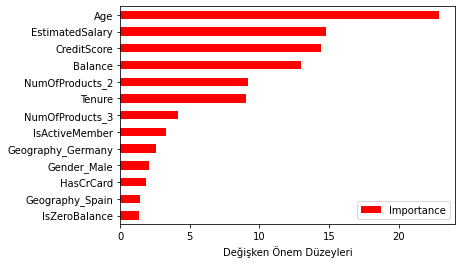

In [39]:
# Değişkenlerin önem seviyesinin Random Forest ile belirlenmesi
Importance = pd.DataFrame({"Importance": rf_model.feature_importances_*100},
                         index = X_train.columns)
 

Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "r")

plt.xlabel("Değişken Önem Düzeyleri")

### Random Forest - Parametre Seçimi

In [46]:
rf_params = {"max_depth": [10, 100],
            "max_features": [2,6,12],
            "n_estimators": [100, 500, 1000],
            "min_samples_split": [2, 5],
            "min_samples_leaf" : [1, 2]}

rf_model = RandomForestClassifier()

rf_cv_model = GridSearchCV(rf_model, 
                           rf_params, 
                           cv = 10, 
                           n_jobs = -1, 
                           verbose = 2) 

In [47]:
rf_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 13.9min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 100], 'max_features': [2, 6, 12],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 500, 1000]},
             verbose=2)

In [48]:
print("En iyi parametreler: " + str(rf_cv_model.best_params_))

En iyi parametreler: {'max_depth': 100, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}


### GBM - Parametre Seçimi

In [49]:
gbm_params = {"learning_rate" : [0.01, 0.1],
              "n_estimators": [100, 1000],
              "max_depth": [10, 50, 100],
              "min_samples_split": [2, 5]}

gbm = GradientBoostingClassifier()

In [50]:
gbm_cv = GridSearchCV(gbm, gbm_params, cv = 10, n_jobs = -1, verbose = 2)

gbm_cv.fit(X_train, y_train)

print("En iyi parametreler: " + str(gbm_cv.best_params_))

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 31.0min finished


En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 100, 'min_samples_split': 5, 'n_estimators': 1000}


### XGBoost - Parametre Seçimi

In [51]:
xgb_params = {
        'n_estimators': [1000, 2000, 3000],
        'subsample': [0.3, 0.6, 1.0],
        'max_depth': [10, 50, 100],
        'learning_rate': [0.1, 0.01, 0.05],
        "min_samples_split": [2, 5]}

xgb = XGBClassifier()

xgb_cv_model = GridSearchCV(xgb, xgb_params, cv = 10, n_jobs = -1, verbose = 2)

In [52]:
xgb_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 67.1min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 129.7min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 186.1min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 208.4min finished


[19:07:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:07:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None

In [53]:
xgb_cv_model.best_params_

{'learning_rate': 0.01,
 'max_depth': 50,
 'min_samples_split': 2,
 'n_estimators': 2000,
 'subsample': 0.6}

### LightGBM - Parametre Seçimi

In [54]:
lgbm_params = {
        'n_estimators': [100, 500, 1000, 2000],
        'subsample': [0.3, 0.6, 1.0],
        'max_depth': [10, 50, 100],
        'learning_rate': [0.1, 0.2, 0.05],
        "min_child_samples": [5, 10, 20]}

lgbm = LGBMClassifier()

lgbm_cv_model = GridSearchCV(lgbm, lgbm_params, 
                             cv = 10, 
                             n_jobs = -1, 
                             verbose = 2)

In [55]:
lgbm_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 43.3min finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=10, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.05],
                         'max_depth': [10, 50, 100],
                         'min_child_samples': [5, 10, 20],
                         'n_estimators': [100, 500, 1000, 2000],
                         'subsample': [0.3, 0.6, 1.0]},
             verbose=2)

In [56]:
lgbm_cv_model.best_params_

{'learning_rate': 0.1,
 'max_depth': 50,
 'min_child_samples': 5,
 'n_estimators': 2000,
 'subsample': 0.3}

### CatBoost - Parametre Seçimi

In [57]:
cat_params = {
    'iterations': [200, 500, 1000],
    'learning_rate': [0.01,0.05, 0.1, 0,2],
    'depth': [3, 5, 8] }

cat = CatBoostClassifier()
cat_cv_model = GridSearchCV(cat, cat_params, cv=5, n_jobs = -1, verbose = 2)
cat_cv_model.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  9.3min finished


0:	learn: 0.6379194	total: 21.1ms	remaining: 21.1s
1:	learn: 0.6008646	total: 34.2ms	remaining: 17.1s
2:	learn: 0.5654814	total: 48.9ms	remaining: 16.2s
3:	learn: 0.5389442	total: 62.8ms	remaining: 15.6s
4:	learn: 0.5185372	total: 76.1ms	remaining: 15.2s
5:	learn: 0.5017125	total: 96.3ms	remaining: 16s
6:	learn: 0.4897418	total: 111ms	remaining: 15.7s
7:	learn: 0.4770270	total: 130ms	remaining: 16.2s
8:	learn: 0.4671363	total: 145ms	remaining: 16s
9:	learn: 0.4574476	total: 162ms	remaining: 16s
10:	learn: 0.4509510	total: 178ms	remaining: 16s
11:	learn: 0.4458975	total: 191ms	remaining: 15.8s
12:	learn: 0.4413836	total: 205ms	remaining: 15.5s
13:	learn: 0.4356823	total: 220ms	remaining: 15.5s
14:	learn: 0.4312466	total: 243ms	remaining: 15.9s
15:	learn: 0.4265271	total: 257ms	remaining: 15.8s
16:	learn: 0.4235134	total: 271ms	remaining: 15.7s
17:	learn: 0.4210490	total: 285ms	remaining: 15.6s
18:	learn: 0.4155317	total: 299ms	remaining: 15.5s
19:	learn: 0.4129508	total: 312ms	remaining

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000211BA1FD880>,
             n_jobs=-1,
             param_grid={'depth': [3, 5, 8], 'iterations': [200, 500, 1000],
                         'learning_rate': [0.01, 0.05, 0.1, 0, 2]},
             verbose=2)

In [58]:
cat_cv_model.best_params_

{'depth': 8, 'iterations': 1000, 'learning_rate': 0.1}